In [196]:
import requests
import bs4
import re
import pandas as pd
import json
import numpy as np
from bs4 import BeautifulSoup
file_path = 'data/'

# JSON 파일 불러오기
with open(file_path + 'PREFIX.json', 'r', encoding='utf-8') as f:
    PREFIX = json.load(f)
with open(file_path + 'SUFFIX.json', 'r', encoding='utf-8') as f:
    SUFFIX = json.load(f)


In [197]:

# 기존 구조: nested 딕셔너리 만들기
req_parameter_nested = {
    region: {
        district: PREFIX[region] + suffix[-3:]
        for district, suffix in districts.items()
    }
    for region, districts in SUFFIX.items()
}

# 평탄화(flatten) + 시단위 전체 지역 코드 추가
req_parameter = {}

for region, districts in req_parameter_nested.items():
    # 시 전체 ('서울') 코드: '강남구'처럼 직접 접근할 수 있도록
    if '전체' in districts:
        req_parameter[region] = districts['전체']  # ex) '서울': '101000'
    # 각 구/군도 추가
    for district, code in districts.items():
        req_parameter[district] = code

req_parameter2={
    '지역별':'domestic',
    '직업별':'job-category',
    '역세권별':'subway',
    'HOT100':'hot100',
    '헤드헌팅':'headhunting'
}


In [ ]:
def parse_location_input(user_input):

    # 3. 지역명을 코드로 변환
    region_codes = []
    for region in user_input:
        code = req_parameter.get(region)
        if code:
            region_codes.append(code)
        else:
            print(f"경고: '{region}' 지역을 찾을 수 없습니다.")

    return "%2C".join(region_codes)  # URL 인코딩된 콤마

loc_cd_param = parse_location_input(['서울', '부산', '경기','인천','광주','대구','대전'])

경고: '대전전' 지역을 찾을 수 없습니다.


In [ ]:
job_link_list = []
corp_link_list = []
logo_list = []
title_list =[]
job_list = []
corp_list = []
local_list = []
exp_list = []
grad_list = []
date_list = []
badge_list = []
upload_list = []
for page in range(1,50):
    url = "https://www.saramin.co.kr/zf_user/jobs/list/{지역별}?page={page}&loc_cd={loc_cd_param}&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y".format(page=page, **req_parameter2, loc_cd_param=loc_cd_param)
    print(url)
    req_header = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
    }

    res = requests.get(url, headers = req_header)
    res.encoding = 'utf-8'

    
    if res.ok:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser') 
        # CSS 선택자
        a_tag_list = soup.select("div#default_list_wrap div.list_body div.box_item")
        # <a> 태그 리스트 순회하기    
        for a_tag in a_tag_list:
            # 링크
            job_link_dict = {}
            if a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit") == None:
                print(a_tag.find("div", class_ ="job_tit"))
                job_link_dict['링크'] = 'NULL'
            else:
                job_link_dict['링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit")['href']
            job_link_list.append(job_link_dict)

            # 회사 링크
            corp_link_dict = {}
            if a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit") == None:
                corp_link_dict['회사링크'] = 'NULL'
            else:
                corp_link_dict['회사링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit")['href']
            corp_link_list.append(corp_link_dict)

            # 로고
            # logo_dict = {}
            # if len(a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")) == 0:
            #     logo_dict['로고'] = 'Null'
            # else:
            #     img_url = a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")
            #     logo_dict['로고'] = img_url[0]['src']
            # logo_list.append(logo_dict)

            # 제목
            title_dict = {}
            if len(a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")) == 0:
                title_dict['제목'] = 'Null'
            else:
                title = a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")[0].text
                title_dict['제목'] = title
            title_list.append(title_dict)

            # 회사
            corp_dict = {}
            if len(a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit")) == 0:
                corp_dict['회사'] = 'Null'
            else:
                corp = a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit").text
                corp_dict['회사'] = corp
            corp_list.append(corp_dict)
            clean_corp = []
            for item in corp_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_corp.append(clean_item)
            
            # 직무
            job_dict = {}
            job = a_tag.select_one('.job_sector')
            if len(job) == 0:
                job_dict['직무'] = 'Null'
            else:
                jobs = [span.get_text(strip=True).replace('::before', '').strip() for span in job.find_all('span')]
                job_dict['직무'] = jobs
            job_list.append(job_dict)
            
            # 지역, 경력, 학력
            temp = a_tag.find("div", class_ = "col recruit_info")
            local_dict = {}
            exp_dict = {}
            grad_dict = {}
            if len(temp) >= 3:
                local_dict['지역'] = temp.find("p", class_ = "work_place").text
                exp_dict['요구경력'] = temp.find("p", class_ = "career").text
                grad_dict['최소학력'] = temp.find("p", class_ = "education").text
            else:
                local_dict['지역'] = 'NULL'
                exp_dict['요구경력'] = 'NULL'
                grad_dict['최소학력'] = 'NULL'
            local_list.append(local_dict)
            exp_list.append(exp_dict)
            grad_list.append(grad_dict)

            for region in local_list:
                if region['지역'].endswith(' 외'):
                    region['지역'] = region['지역'][:-2]

            # 기간
            date_dict = {}
            if len(a_tag.select("span.date")) == 0:
                date_dict['기간'] = 'Null'
            else:
                date = a_tag.select("span.date")[0].text
                date_dict['기간'] = date
            date_list.append(date_dict)

            clean_date = []
            for item in date_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_date.append(clean_item)

            # 등록일자
            upload_dict = {}
            if len(a_tag.select_one("span.deadlines")) == 0:
                upload_dict['등록일자'] = 'Null'
            else:
                upload = a_tag.select("span.deadlines")[0].text
                upload_dict['등록일자'] = upload
            upload_list.append(upload_dict)

            # 배지
            badge_dict = {}
            if a_tag.select_one(".job_badge") == None:
                badge_dict['배지'] = 'Null'
            else:
                badge = a_tag.select_one(".job_badge").find("span").text
                badge_dict['배지'] = badge
            badge_list.append(badge_dict)
            clean_badge = []
            for item in badge_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_badge.append(clean_item)

    else:
        # 응답(response)이 Error 이면 status code 출력    
        print(f'에러 코드 1= {res.status_code}')


In [200]:

combined_list = []
for link, corp_link, title, corp, job, local, exp, grad, date, upload, badge in zip(job_link_list, corp_link_list,title_list, clean_corp, job_list, local_list, exp_list, grad_list, clean_date, upload_list, clean_badge):
    merged_dict = {}
    merged_dict.update(link)
    merged_dict.update(corp_link)
    merged_dict.update(title)
    merged_dict.update(corp)
    merged_dict.update(job)
    merged_dict.update(local)
    merged_dict.update(exp)
    merged_dict.update(grad)
    merged_dict.update(date)
    merged_dict.update(upload)
    merged_dict.update(badge)
    combined_list.append(merged_dict)



In [ ]:

# DataFrame으로 변환
df = pd.DataFrame(combined_list)
print(job_link_list)
df.head()

In [202]:
# '원문' 열 만들기 (기존 요구경력 복사)
df['원문'] = df['요구경력']

def split_info(text):
    if not isinstance(text, str):
        return pd.Series([None, None])
    
    parts = re.split(r'\s*·\s*', text)

    if len(parts) >= 2:
        exp = ' · '.join(parts[:-1]).strip()
        job_type = re.sub(r'\s*외$', '', parts[-1].strip())
        return pd.Series([exp, job_type])
    else:
        return pd.Series([text.strip(), None])
    
# 위에서 고친 split_info 함수 적용
df[['요구경력_raw', '계약종류']] = df['원문'].apply(split_info)

# 문자열 확인 추가된 normalize 함수
def normalize_experience(exp):
    if not isinstance(exp, str):
        return None  # 또는 '기타', '불명' 등

    exp = exp.strip()
    if '신입' in exp and '경력' in exp:
        return '신입/경력'
    elif '신입' in exp:
        return '신입'
    elif '경력무관' in exp or '년수무관' in exp:
        return '경력무관'
    elif re.match(r'경력 \d+년↑', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이상'
    elif re.match(r'경력 \d+년↓', exp):
        years = re.findall(r'\d+', exp)[0]
        return f'{years}년 이하'
    elif re.match(r'\d+ ~ \d+년', exp):
        return exp.replace(' ', '')
    elif exp == '경력':
        return '경력'
    else:
        return exp

# 적용
df['요구경력'] = df['요구경력_raw'].apply(normalize_experience)
df.drop(columns=['요구경력_raw'], inplace=True)
df['계약종류'].unique()

array(['정규직', '계약직', '파트', '아르바이트', '프리랜서', '인턴직', '위촉직', '파견직', '전임',
       '교육생', None, '경력'], dtype=object)

In [ ]:
df['등록일자'].unique()

In [204]:
import re

def process_registration_date(text):
    if not isinstance(text, str):
        return None
    
    # '수정'과 '등록' 제거
    text = re.sub(r'\s*(수정|등록)\s*', '', text)
    
    # 'n시간 전'을 '당일'로 변경
    text = re.sub(r'\d+\s*시간\s*전', '당일', text)
    
    # 'n분 전'은 그대로 두기
    text = re.sub(r'\d+\s*분\s*전', '당일', text)
    
    return text.strip()

# 적용
df['등록일자'] = df['등록일자'].apply(process_registration_date)

In [ ]:
df['등록일자'].unique()

In [ ]:
df['기간'].unique()

In [207]:
df.head()

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지,원문,계약종류
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,그린써브 물류센터 입출고직원 채용(지게차필수)연봉5천이상,그린써브(주),[피킹(집품)],경기 평택시,경력무관,학력무관,~06.15(일),당일,Null,경력(년수무관) · 정규직,정규직
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,NULL,[hetras]구매 담당자,(주)쑥쑥컴퍼니,"[구매관리, 구매기획, 거래처관리, 구매대행/소싱, 납기관리]",서울전체,2년 이상,고졸↑,~05.15(목),당일,취업축하금,경력 2년↑ · 정규직,정규직
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[인투온] 관리팀(세무/회계/정산관리) 경력직 채용,(주)인투온,"[전산회계, 더존, 법인결산, 법인세신고, 부가세신고]",서울전체,4~10년,"대학(2,3년)↑",~04.30(수),2일 전,회계·세무·재무 지원 TOP100,4 ~ 10년 · 정규직,정규직
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,NULL,"자동차업계 품질관리, 품질보증 경력직 모집(대리-과장급)",지에스,"[품질관리, 품질보증]",경기 안성시,3~7년,"대학(2,3년)↑",~05.09(금),당일,워라밸,3 ~ 7년 · 정규직,정규직
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[비앤비플레이]틱톡 라이브 프로그램 진행자(MC) 채용,(주)비앤비플레이,"[방송BJ, 아나운서, 크리에이터, MC]",서울 서초구,경력무관,학력무관,~05.17(토),당일,오늘 뜬,경력무관 · 계약직,계약직


In [208]:
df.replace("NULL", np.nan, inplace=True)
for i in df.columns :
    missingValueRate = df[i].isna().sum() / len(df) * 100
    if missingValueRate > 0 :
        print("{} 결측치 비율: {}%".format(i,round(missingValueRate, 2)))

회사링크 결측치 비율: 6.08%
계약종류 결측치 비율: 0.12%


In [209]:
df.shape

(2450, 13)

In [210]:

df.dropna(axis = 0, inplace=True)
df.shape

(2298, 13)

In [211]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = 'C:\\windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()


matplotlib.rc('font', family=font_prop)

In [212]:
dev_df = df[df['제목'].str.contains('개발', na=False)]

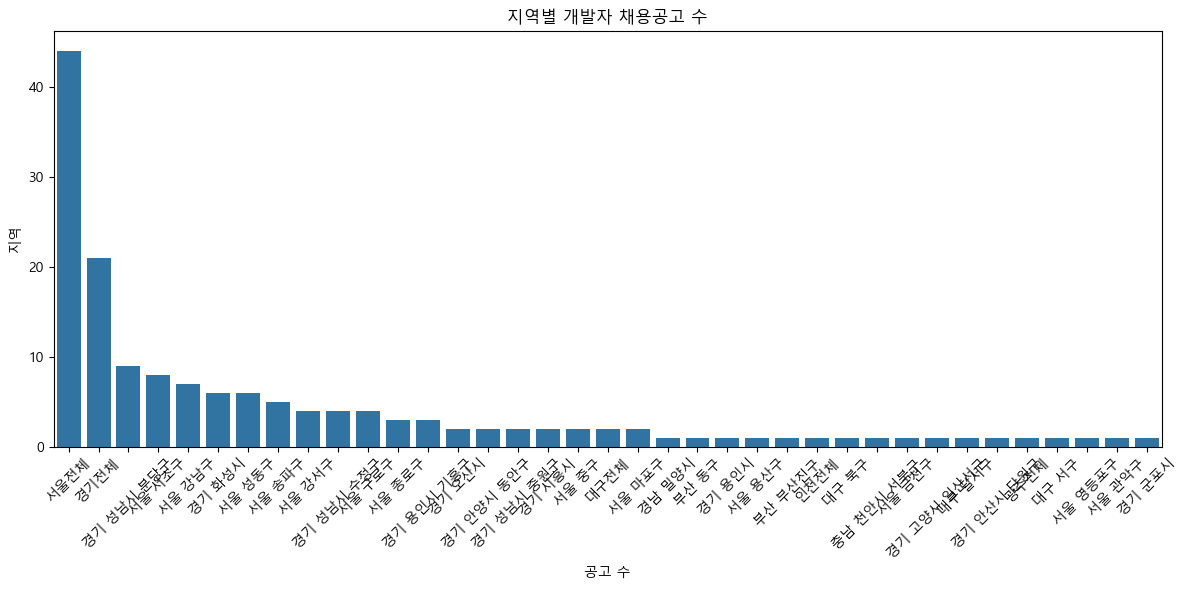

In [213]:

# 지역별 공고 수
plt.figure(figsize=(12, 6))
sns.countplot(data=dev_df, x='지역', order=dev_df['지역'].value_counts().index)
plt.title('지역별 개발자 채용공고 수')
plt.xlabel('공고 수')
plt.ylabel('지역')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

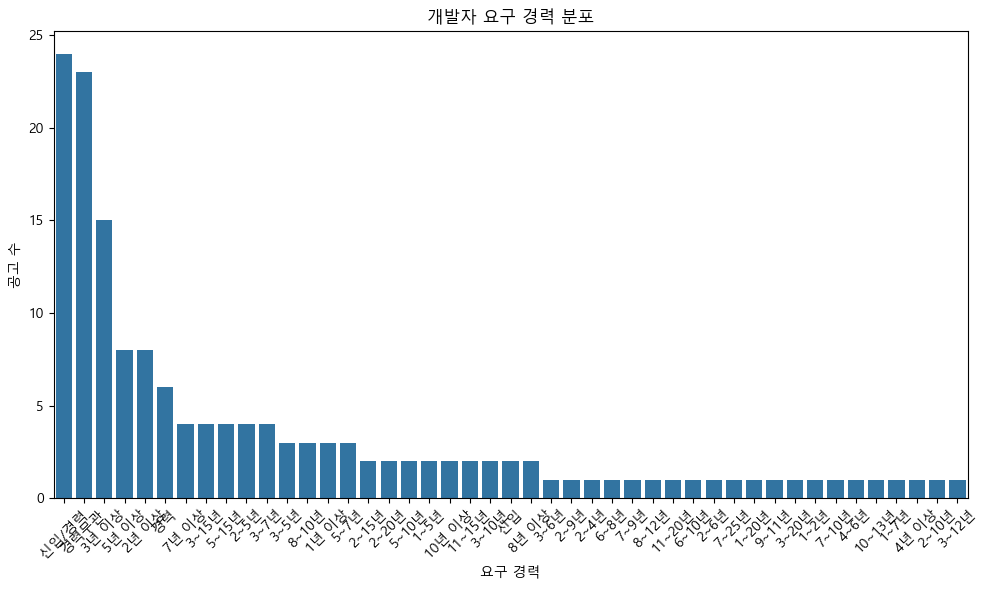

In [214]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dev_df, x='요구경력', order=dev_df['요구경력'].value_counts().index)
plt.title('개발자 요구 경력 분포')
plt.xlabel('요구 경력')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

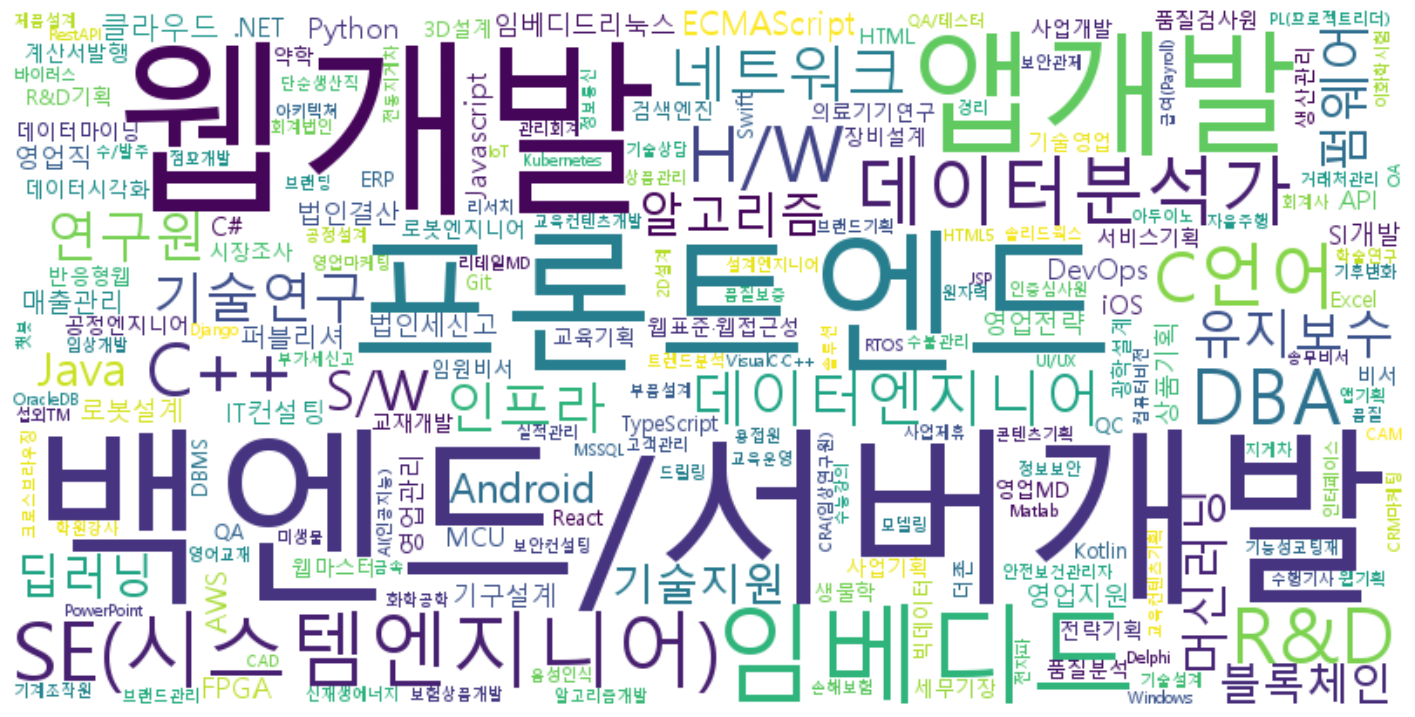

In [215]:
from wordcloud import WordCloud
df_exploded = dev_df.explode('직무')
job_counts = df_exploded['직무'].value_counts()

wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(job_counts.to_dict())

plt.figure(figsize=(18, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

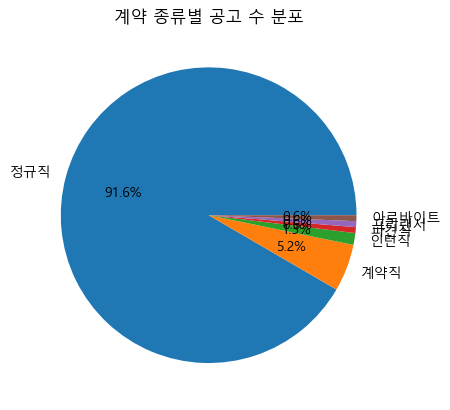

In [216]:
contract_counts = dev_df['계약종류'].value_counts()

contract_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('계약 종류별 공고 수 분포')
plt.ylabel('')
plt.show()

In [219]:
df.loc[df['회사'] == df['회사'].unique()]

ValueError: ('Lengths must match to compare', (2298,), (1606,))

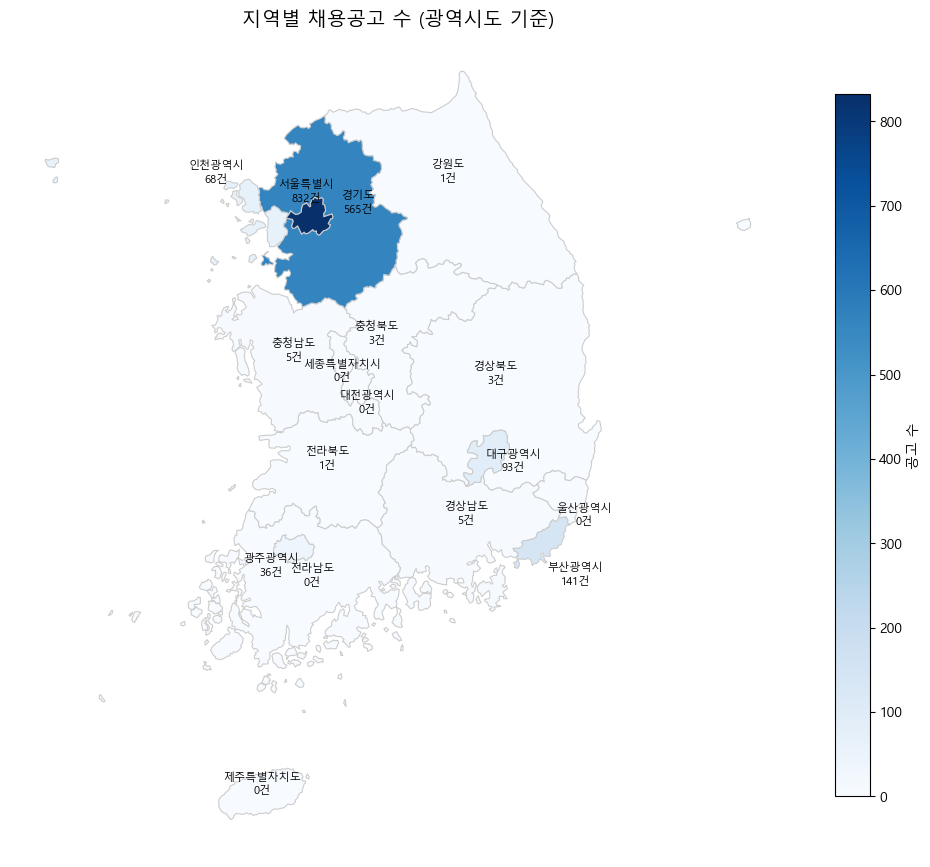

In [217]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. 지역명을 광역시/도로 변환하는 함수
def convert_region(name):
    if name == '전국':
        return None
    parts = name.split()
    region_map = {
        '서울': '서울특별시', '부산': '부산광역시', '대구': '대구광역시',
        '인천': '인천광역시', '광주': '광주광역시', '대전': '대전광역시',
        '울산': '울산광역시', '세종': '세종특별자치시', '경기': '경기도',
        '강원': '강원도', '충북': '충청북도', '충남': '충청남도',
        '전북': '전라북도', '전남': '전라남도', '경북': '경상북도',
        '경남': '경상남도', '제주': '제주특별자치도'
    }
    return region_map.get(parts[0], None)

# 2. 필터된 데이터프레임에 광역시도 열 추가
filtered_df = df[df['지역'] != '서울전체'].copy() 
filtered_df['광역시도'] = filtered_df['지역'].apply(convert_region)

# 3. 지역별 공고 수 집계
region_counts = filtered_df['광역시도'].value_counts().reset_index()
region_counts.columns = ['지역', '공고수']

# 4. GeoJSON 파일 불러오기
gdf = gpd.read_file('data/skorea_provinces_geo_simple.json')

# 5. 병합 (left join으로 모든 지역 유지)
merged = gdf.merge(region_counts, left_on='name', right_on='지역', how='left')
merged['공고수'] = merged['공고수'].fillna(0).astype(int)

# 6. 일부 지역의 라벨이 겹치지 않도록 위치 보정값 정의
label_offsets = {
    '서울특별시': (0, 0.1),
    '세종특별자치시': (0, -0.2),
    '인천광역시': (-0.3, 0.1),
    '대전광역시': (0.1, -0.2),
    '광주광역시': (-0.2, -0.2),
    '대구광역시': (0.2, -0.1),
    '부산광역시': (0.3, -0.3),
    '울산광역시': (0.2, -0.2),
}

# 7. 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
merged.plot(
    column='공고수',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.6, 'label': '공고 수'}
)

# 8. 지도 위에 텍스트 표시 (지역명 + 공고수)
for idx, row in merged.iterrows():
    point = row.geometry.representative_point()
    dx, dy = label_offsets.get(row['name'], (0, 0))
    plt.annotate(
        text=f"{row['name']}\n{row['공고수']}건",
        xy=(point.x + dx, point.y + dy),
        ha='center',
        fontsize=8,
        color='black'
    )

plt.title('지역별 채용공고 수 (광역시도 기준)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
